<a href="https://colab.research.google.com/github/mukhinaks/cnn_course/blob/master/CNN_Intro_LeNet_5_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take a look to LeNet-5 - small convolutional neural network which is able to classify hand-written digits.

It was proposed in 1998 by Yann LeCun [[link](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)].

In [ ]:
#Import pytorch and download data
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

batch_size = 128

transform = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                ]) 

mnist_train = datasets.MNIST('', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = datasets.MNIST('', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False)

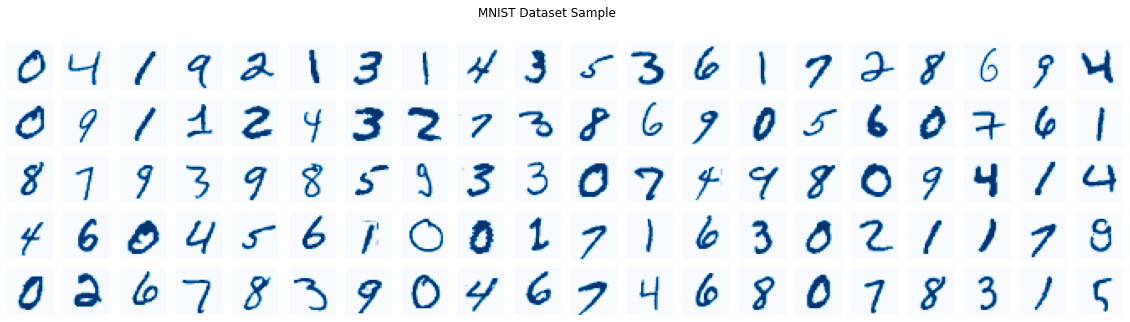

In [ ]:
#Take a look on the sample
fig = plt.figure( figsize=(20,5))
for index in range(1, 5 * 20 + 1):
    plt.subplot(5, 20, index)
    plt.axis('off')
    plt.imshow(mnist_train.data[index], cmap='Blues')
fig.suptitle('MNIST Dataset Sample')

In [ ]:
'''
Several comments regarding original article:

- In paper, Average pool was used, in modern works Max pool is more common.
- In original work, activation is applied after pooling, nowadays, activation is applied right after convolution. 
- We use SoftMax as activation for output, since activation used in original work is currently outdated.
- In article, C5 layer is called Convolution layer, but in fact we can use FC-layer here. 
  Modify model by changing FC-layer by Conv2D.
- Tanh and Sigmoid were used as activation in the model, 
  however, Conv+ReLU is more popular combination which provide better results.
  
'''

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.lenet  = nn.Sequential(
                          nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=2, stride=2),   
                          nn.Flatten(),
                          nn.Linear(in_features=400, out_features=120),
                          nn.ReLU(),                          
                          nn.Linear(in_features=120, out_features=84),
                          nn.ReLU(),
                          nn.Linear(in_features=84, out_features=10),
                        )


    def forward(self, x):
        x = self.lenet(x)
        labels = torch.softmax(x, dim = 1)
        return x, labels

In [ ]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() #* X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.dataset)
    return model, optimizer, running_loss

In [ ]:
def validate(valid_loader, model, criterion):   
    model.eval()
    running_loss = 0
    correct = 0
    for X, y_true in valid_loader:
        y_hat, labels = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.data.item() #* X.size(0)

        pred = np.argmax(labels, axis=1)
        correct = correct + np.equal(pred, y_true.data).sum()

    running_loss /= len(valid_loader.dataset)
        
    return model, running_loss, correct

In [ ]:
def run(model, criterion, optimizer, train_loader, valid_loader, epochs = 100):
    train_losses = []
    valid_losses = []
    correct_prediction = []

    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        with torch.no_grad():
            model, valid_loss, correct = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)
            correct_prediction.append(correct)

                
        print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Correct predictions: {correct.data.item()}/{len(valid_loader.dataset)}'
              )
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
torch.manual_seed(42)

model = LeNet5()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
model, optimizer, (train_losses, valid_losses) = run(model, criterion, optimizer, train_loader, test_loader, 10)

Epoch: 0	Train loss: 0.3687	Valid loss: 0.0996	Correct predictions: 9697/10000
Epoch: 1	Train loss: 0.0962	Valid loss: 0.0664	Correct predictions: 9793/10000
Epoch: 2	Train loss: 0.0676	Valid loss: 0.0595	Correct predictions: 9812/10000
Epoch: 3	Train loss: 0.0535	Valid loss: 0.0425	Correct predictions: 9857/10000
Epoch: 4	Train loss: 0.0434	Valid loss: 0.0389	Correct predictions: 9868/10000
Epoch: 5	Train loss: 0.0354	Valid loss: 0.0367	Correct predictions: 9889/10000
Epoch: 6	Train loss: 0.0321	Valid loss: 0.0349	Correct predictions: 9882/10000
Epoch: 7	Train loss: 0.0284	Valid loss: 0.0379	Correct predictions: 9887/10000
Epoch: 8	Train loss: 0.0241	Valid loss: 0.0332	Correct predictions: 9895/10000
Epoch: 9	Train loss: 0.0211	Valid loss: 0.0307	Correct predictions: 9895/10000


Text(0.5, 0.98, 'MNIST Dataset Sample')

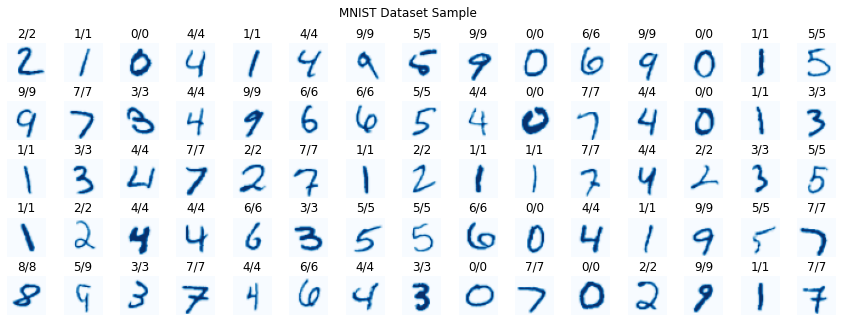

In [ ]:
#Let's see the results

fig = plt.figure( figsize=(15,5))
plt.subplots_adjust(hspace = 0.5)

for index in range(1, 5 * 15 + 1):
    ax = plt.subplot(5, 15, index)
    plt.axis('off')
    plt.imshow(test_loader.dataset[index][0].squeeze(), cmap='Blues')

    _, labels = model(test_loader.dataset[index][0].unsqueeze(0)) 
    pred = np.argmax(labels.detach().numpy(), axis=1)
    ax.set_title( str(pred[0]) + '/' + str(test_loader.dataset[index][1]))

fig.suptitle('MNIST Dataset Sample')